In [1]:
import os
from typing import Any, Sequence, Union

import lightning as L
import matplotlib.pyplot as plt
import torch
import torchvision
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler
from torchvision.datasets.cifar import CIFAR10
from tqdm import tqdm

from models.unet import DiffusionUNet

In [2]:
class LightingDiffusion(L.LightningModule):
    def __init__(
        self,
        T: int = 1000,
        beta_start: float = 1e-4,
        beta_end: float = 0.02,
    ):
        super().__init__()
        self.model = DiffusionUNet()
        self.T = T
        betas = torch.linspace(beta_start, beta_end, T)
        alphas = torch.ones_like(betas) - betas
        alpha_bars = torch.cumprod(
            alphas, dim=0,
        )  # zero indexed
        sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - alpha_bars)
        
        # Register as buffers to move to correct device automatically
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alpha_bars', alpha_bars)
        self.register_buffer('sqrt_one_minus_alpha_bars', sqrt_one_minus_alpha_bars)

    def training_step(self, batch, batch_idx):
        batch = batch[0]  # remove label information
        
        # Sample random values from 0 to T - 1
        batch_size = batch.shape[0]
        # print('batch shape', batch.shape)
        t_batch = torch.randint(0, self.T, (batch_size,), device=self.device)
        # print('t batch shape', t_batch.shape)

        assert batch.shape[0] == t_batch.shape[0]

        # print("t_shape", t_batch.shape)

        noise = torch.randn_like(batch)
        alpha_bars_batch = self.alpha_bars[t_batch].view(batch_size, 1, 1, 1)
        sqrt_one_minus_alpha_bars_batch = self.sqrt_one_minus_alpha_bars[t_batch].view(
            batch_size, 1, 1, 1
        )

        noised_batch = (
            alpha_bars_batch * batch + sqrt_one_minus_alpha_bars_batch * noise
        )

        # print("moised batch shape", noised_batch.shape)
        # print("t batch shape", t_batch.shape)
        pred_noise = self.model(
            noised_batch,
            t_batch,
        )

        loss = torch.nn.functional.mse_loss(noise, pred_noise)

        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def sample_ddpm(self, n_imgs: int, img_size: int):
        """
        Use DDPM iterative sampling to generate a batch of new images (B x 3 x size x size)
        """
        
        x_t = torch.randn((n_imgs, 3, img_size, img_size))
        with torch.no_grad():
            for t in tqdm(reversed(range(self.T))):
                t_tensor = torch.ones(n_imgs) * t
                z = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)
                
                pred_denoise = self.model(x_t, t_tensor)
                
                alpha_t = self.alphas[t]
                alpha_bar_t = self.alpha_bars[t]
                beta_t = self.betas[t]
                
                x_next = x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * pred_denoise
                
                x_t = 1 / torch.sqrt(alpha_t) * x_next + beta_t ** 0.5 * z
        return x_t

    def sample_ddim(self):
        """
        Sample from the model using DDIM: adjust standard deviation accordingly
        """
        pass

    def configure_optimizers(self) -> OptimizerLRScheduler:
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

In [3]:
diffusion = LightingDiffusion()

# setup data for MNIST
torchvision.datasets.CIFAR10.url = torchvision.datasets.CIFAR10.url.replace(
    "https://", "http://"
)
dataset = torchvision.datasets.CIFAR10(
    os.path.dirname(os.getcwd()) + "/data",
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128)

# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(max_epochs=1, default_root_dir=os.getcwd() + "/../results")
trainer.fit(model=diffusion, train_dataloaders=train_loader)

Files already downloaded and verified


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/avaliveru/miniforge3/envs/diffusion/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type          | Params
----------------------------------------
0 | model | DiffusionUNet | 168 M 
----------------------------------------
168 M     Trainable params
0         Non-trainable params
168 M     Total params
675.544   Total estimated model params size (MB)
/Users/ava

Epoch 0:   2%|▏         | 9/391 [00:24<17:39,  0.36it/s, v_num=1, train_loss_step=0.379]  

In [ ]:
# diffusion = LightingDiffusion.load_from_checkpoint(
#     "../results/lightning_logs/version_1/checkpoints/epoch=0-step=391.ckpt"
# )

# diffusion.eval()

In [ ]:
diffusion.eval()
img = diffusion.sample_ddpm(256, 32)

0it [00:00, ?it/s]


RuntimeError: Placeholder storage has not been allocated on MPS device!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


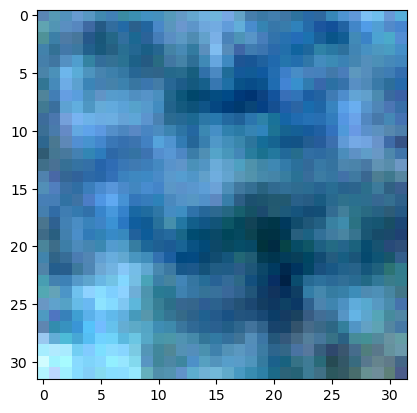

In [ ]:
for i in range(256, )
plt.imshow(img[0].permute(1, 2, 0))